<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Experiments/covid_facemask_and_social_distance/covid_deployment_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download covid model 

Lets mount the model and download it to disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !cp -Rv "/content/drive/My Drive/datasets/facemask/detectron_d5_person+mask_faster_rcnn_R_50_FPN_1x" output

Mounted at /content/drive


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
assert torch.__version__.startswith("1.6")
!pip install pyyaml==5.1 pycocotools>=2.0.1
!pip uninstall -y detectron2
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 3.7MB/s 
     |████████████████████████████████| 2.2MB 8.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20200929-cp36-none-any.whl size=43976 sha256=064a567fb7316b27675d71ad58870b1ecc6a1c21a776b5a6b44b95e46710b18d
  Stored in directory: /root/.cache/pip/wheels/89/55/50/16407a05a12ac87ccf596350724c707f5ca77809b25f802b93
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


### Load model

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

In [ ]:
classes = ['person', 'mask', 'nomask']

cfg = get_cfg()
model_yaml = "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(model_yaml))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # set threshold for this model
# cfg.MODEL.WEIGHTS = "output/model_final.pth"
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/datasets/facemask/detectron_d5_person+mask_faster_rcnn_R_50_FPN_1x_10k/model_final.pth"
# cfg.MODEL.WEIGHTS = "/content/drive/My Drive/datasets/facemask/detectron_d4_faster_rcnn_R_50_FPN_1x/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Single image infer model
predictor = DefaultPredictor(cfg)


# Batch infer model 
model = build_model(cfg)
# model_dict = torch.load(cfg.MODEL.WEIGHTS,)
# model.load_state_dict(model_dict['model'])
_ = DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

### Test model

In [ ]:
#Function to display the bounding box on the image
def draw_predictions(img, output):
    pred_boxes = output['instances'].pred_boxes
    scores = output['instances'].scores.cpu().numpy()
    pred_classes = output['instances'].pred_classes.cpu().numpy()
    print(pred_classes)
    for i in range(len(scores)):
        box = pred_boxes[i].__dict__['tensor'].cpu().numpy()[0]
        x1, y1, x2, y2 = box
        _ = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255) , 1)
        color = (255, 0, 0)
        if pred_classes[i] == 0:
            color = (0, 0, 0)
        if pred_classes[i] == 2:
            color = (0, 255, 0)
        class_name = classes[pred_classes[i]] if pred_classes[i] < len(classes) else pred_classes[i]
        text = "%s %d %%" % (class_name, scores[i] * 100)
        _ = cv2.rectangle(img, (int(x1), int(y1 + 3)), (int(x1 + 75), int(y1 -8)), color, -1)
        cv2.putText(img, text, (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv2.LINE_AA)
    cv2_imshow(img)
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
!wget https://images.hindustantimes.com/img/2020/08/19/600x338/abc_1597800367541_1597800372902.jpg  -q -O covid.jpg

#### Testing batch model

/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


{'instances': Instances(num_instances=7, image_height=338, image_width=600, fields=[pred_boxes: Boxes(tensor([[3.1338e+00, 2.6820e-01, 1.5850e+02, 3.2317e+02],
        [5.3199e+02, 6.4209e+01, 6.0000e+02, 3.3800e+02],
        [3.7541e+02, 1.2581e+02, 5.1489e+02, 3.3722e+02],
        [1.6167e+02, 2.4963e+01, 2.5020e+02, 3.3800e+02],
        [4.1339e+02, 1.2186e+02, 4.6843e+02, 1.8598e+02],
        [3.3042e+01, 1.1980e+00, 9.0937e+01, 5.5105e+01],
        [5.6826e+02, 6.8186e+01, 6.0000e+02, 1.3534e+02]], device='cuda:0')), scores: tensor([0.9981, 0.9942, 0.9912, 0.9865, 0.9382, 0.8535, 0.6605],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0')])}
[0 0 0 0 1 1 1]


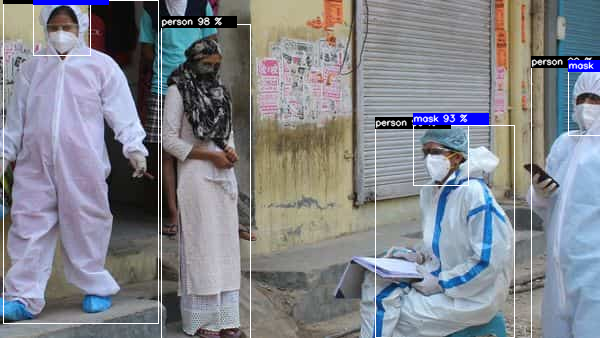

CPU times: user 3.68 s, sys: 3.25 s, total: 6.93 s
Wall time: 7.28 s


In [ ]:
%%time
img = cv2.imread("covid.jpg")
height, width = img.shape[:2]        
# img_ = np.transpose([2, 0, 1])
img_ = torch.from_numpy(np.transpose(img, [2, 0, 1]))

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)

d = {'image': img_}
model.eval()
with torch.no_grad():
    outputs = model([d] * 64)

print(outputs[0])
draw_predictions(img, outputs[0])
torch.cuda.empty_cache()

#### Testing single infer

{'instances': Instances(num_instances=7, image_height=338, image_width=600, fields=[pred_boxes: Boxes(tensor([[  2.6024,   0.9304, 151.7719, 324.8183],
        [158.6773,  30.2253, 255.8502, 337.5440],
        [524.1401,  61.1857, 597.9697, 335.8176],
        [385.6404, 122.2014, 510.5034, 335.0645],
        [414.6322, 127.8174, 464.8710, 182.1585],
        [ 41.1836,   0.0000,  84.1939,  56.0821],
        [568.5012,  70.2508, 600.0000, 130.4331]], device='cuda:0')), scores: tensor([0.9992, 0.9974, 0.9966, 0.9792, 0.9595, 0.9570, 0.8573],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0')])}
[0 0 0 0 1 1 1]


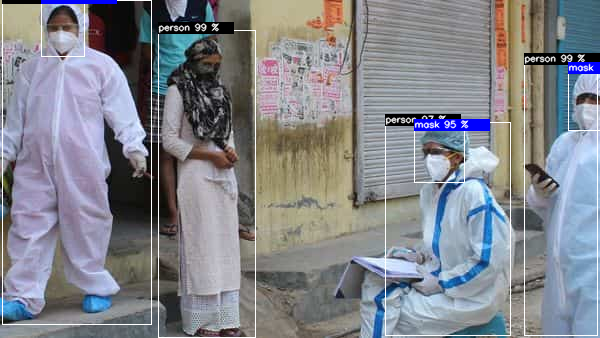

CPU times: user 403 ms, sys: 166 ms, total: 569 ms
Wall time: 574 ms


In [ ]:
%%time
img = cv2.imread("covid.jpg")
outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
print(outputs)
draw_predictions(img, outputs)

### Build Pipeline 

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl > /dev/null

https://i.ytimg.com/an_webp/fPbYaTKKtmA/mqdefault_6s.webp?du=3000&sqp=CMCW8fsF&rs=AOn4CLDBz1d_KHTjWG6RZpO7InSqchoAlg
!youtube-dl https://www.youtube.com/watch?v=L51deDtGLiM -f 22 -o covid_1.mp4
!youtube-dl https://www.youtube.com/watch?v=PTRILP_3Izw -f 22 -o covid_2.mp4
!youtube-dl https://www.youtube.com/watch?v=FmW3zF7DvwE -f 22 -o covid_3.mp4
!youtube-dl https://www.youtube.com/watch?v=CxoL0Agxn34 -f 22 -o covid_4.mp4
!youtube-dl https://www.youtube.com/watch?v=CWx-qpNkYEI -f 22 -o covid_5.mp4

!ffmpeg -i covid_1.mp4 -t 00:00:02 -c:v copy covid_1_clip_2s.mp4 > /dev/null
!ffmpeg -i covid_5.mp4 -t 00:00:02 -c:v copy covid_5_clip_2s.mp4 > /dev/null
!ffmpeg -i covid_1.mp4 -t 00:00:05 -c:v copy covid_1_clip_5s.mp4 > /dev/null
!ffmpeg -i covid_5.mp4 -t 00:00:05 -c:v copy covid_5_clip_5s.mp4 > /dev/null
!ffmpeg -i covid_1.mp4 -t 00:00:10 -c:v copy covid_1_clip_10s.mp4 > /dev/null
!ffmpeg -i covid_5.mp4 -t 00:00:10 -c:v copy covid_5_clip_10s.mp4 > /dev/null

[youtube] L51deDtGLiM: Downloading webpage
[download] Destination: covid_1.mp4
[download] 100% of 5.00MiB in 00:00
[youtube] PTRILP_3Izw: Downloading webpage
[download] Destination: covid_2.mp4
[download] 100% of 8.96MiB in 00:00
[youtube] FmW3zF7DvwE: Downloading webpage
[download] Destination: covid_3.mp4
[download] 100% of 8.97MiB in 00:00
[youtube] CxoL0Agxn34: Downloading webpage
[download] Destination: covid_4.mp4
[download] 100% of 8.69MiB in 00:00
[youtube] CWx-qpNkYEI: Downloading webpage
[download] Destination: covid_5.mp4
[download] 100% of 17.10MiB in 00:00
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enab

In [ ]:
import cv2
from scipy.spatial import distance

def detect_nearest_neighbours(midpoints, num, thresh):
    person_1 = []
    person_2 = []
    distances = []
    for i in range(num):
      for j in range(num):
          if i >= j:
              continue
          distance_ = distance.euclidean(midpoints[i], midpoints[j])
          if not distance_ <= thresh:
              continue
          person_1.append(i)
          person_2.append(j)
          distances.append(distance_)
    return person_1, person_2, distances

#define a function which return the bottom center of every bbox
def mid_point(img, person, idx):
  #get the coordinates
  x1, y1, x2, y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)

  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 3, (0, 255, 0), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)
  return mid

def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)  
  return img

In [ ]:
# # os.mkdir("frames")
# filename = "covid_2.mp4"
# cap = cv2.VideoCapture(filename)
# frameno = 0
# capture_frames = [1857, 3098, 3317, 3370, 3478]
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if frame is None:
#         break
#     frameno += 1
#     if frameno in capture_frames:
#         cv2.imwrite("frames/" + filename + "_%d.jpg" % frameno, frame)
# print("Total frame:", frameno)
# cap.release()

Total frame: 3633


In [ ]:
torch.cuda.empty_cache()

In [ ]:
%%time
import time
import torch
import cv2
out = None
filename = "covid_3.mp4"
outputfile = "processed_" + filename.replace("mp4", 'webm')
cap = cv2.VideoCapture(filename)
frameno = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if frame is None:
        break
    frameno += 1

print("Total frame:", frameno)
cap.release()

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
model.eval()
torch.cuda.empty_cache()

def process_bulk_frames(frameno, imgs):
    imgs_ = [torch.from_numpy(np.transpose(img, [2, 0, 1])) for img in imgs]
    data = [{'image': img_} for img_ in imgs_]
    with torch.no_grad():
        starttime = time.time()
        outputs = model(data)
        model_time = time.time() - starttime
    print(frameno, "batch_size:", len(imgs), imgs[0].shape, model_time)
    return outputs

def process_single_frame(frameno, img):
    starttime = time.time()
    outputs = predictor(img)
    model_time = time.time() - starttime

    if frameno % 10 == 0:
        print(frameno, "batch_size:", 1, img.shape, model_time)
    return outputs

def compute_final_frame(imgs, outputs, frameno):
    global out
    frameno = frameno - len(imgs) + 1
    for cntr, img in enumerate(imgs):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        '''
        Todo: Generate a Top down view to remove false positives.
        Eg. In case of fixed camera locate the parallel lanes and use this to compute 
        top down view and then run algorithm
        '''
        """ Human Distancing Model """
        # Run the Model on our frame image

        pred_classes = outputs[cntr]['instances'].pred_classes.cpu().numpy()
        bbox = outputs[cntr]['instances'].pred_boxes.tensor.cpu().numpy()

        # Filter for Person instances
        ind = np.where(pred_classes==0)[0]

        # After finding all the persons compute their midpoints, here we can tune the algorithm.
        person = bbox[ind]
        midpoints = [mid_point(img, person,i) for i in range(len(person))]
        num = len(midpoints)

        # dist = compute_distance(midpoints, num)
        #  person_1, person_2, distances = find_closest(dist, num, thresh)
        person_1, person_2, distances = detect_nearest_neighbours(midpoints, num, thresh)
        img = change_2_red(img, person, person_1, person_2)
        cv2.putText(img, "Frame: " + str(frameno + cntr), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

        height, width, layers = img.shape
        size = (width, height)

        """ Face Detection Model """
        scores = outputs[cntr]['instances'].scores.cpu().numpy()
        predictions = outputs[cntr]['instances'].pred_classes.cpu().numpy()
        for i in range(len(scores)):
            if classes[predictions[i]] == "person":
                continue

            box = outputs[cntr]['instances'].pred_boxes[i].__dict__['tensor'].cpu().numpy()[0]
            x1, y1, x2, y2 = box

            _ = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 1)
            # _ = cv2.circle(img, mid, 3, (0, 255, 0), -1)
            text = "%s %d %%" % (classes[predictions[i]], int(scores[i] * 100))

            color = (255, 0, 0)
            if classes[predictions[i]] == "mask":
                color = (0, 255, 0)
            _ = cv2.rectangle(img, (int(x1), int(y1 + 3)), (int(x1 + 100), int(y1 -8)), color, -1)
            cv2.putText(img, text, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv2.LINE_AA)    
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        # size = (960, 450)
        # img = cv2.resize(img, size)

        if not out:
            out = cv2.VideoWriter(outputfile, cv2.VideoWriter_fourcc(*'vp80'), 25, size)
        out.write(img)

thresh = 100
frameno = 0
bulk = True
batch_size = 16
imgs = []

cap = cv2.VideoCapture(filename)
while(cap.isOpened()):
    ret, frame = cap.read()
    if frame is None:
        if len(imgs):
            outputs = process_bulk_frames(frameno, imgs)
            compute_final_frame(imgs, outputs, frameno)
        break

    frameno += 1
    img = frame
    if bulk:
        imgs.append(img)
        if len(imgs) == batch_size:
            outputs = process_bulk_frames(frameno, imgs)
            compute_final_frame(imgs, outputs, frameno)
            imgs = []
    else:
        outputs = process_single_frame(frameno, img)
        compute_final_frame([img], [outputs], frameno)
out.release()
torch.cuda.empty_cache()

Total frame: 3631
16 batch_size: 16 (720, 1280, 3) 0.803844690322876
32 batch_size: 16 (720, 1280, 3) 0.824476957321167
48 batch_size: 16 (720, 1280, 3) 0.797492265701294
64 batch_size: 16 (720, 1280, 3) 0.7948455810546875
80 batch_size: 16 (720, 1280, 3) 0.808361291885376
96 batch_size: 16 (720, 1280, 3) 0.8173496723175049
112 batch_size: 16 (720, 1280, 3) 0.8109066486358643
128 batch_size: 16 (720, 1280, 3) 0.8042128086090088
144 batch_size: 16 (720, 1280, 3) 0.8002562522888184
160 batch_size: 16 (720, 1280, 3) 0.8047301769256592
176 batch_size: 16 (720, 1280, 3) 0.7942767143249512
192 batch_size: 16 (720, 1280, 3) 0.8010339736938477
208 batch_size: 16 (720, 1280, 3) 0.7901792526245117
224 batch_size: 16 (720, 1280, 3) 0.7938246726989746
240 batch_size: 16 (720, 1280, 3) 0.797112226486206
256 batch_size: 16 (720, 1280, 3) 0.7937922477722168
272 batch_size: 16 (720, 1280, 3) 0.813615083694458
288 batch_size: 16 (720, 1280, 3) 0.8133797645568848
304 batch_size: 16 (720, 1280, 3) 0.8106

In [ ]:
# Run the function, get the video path as saved in your notebook, and play it back here.
from IPython.display import HTML
from base64 import b64encode
video_width = 300
video_file = open(outputfile, "rb").read()
# video_file = open(filename, "rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")